#Multi Modal (Morphometry+Connectome) GCN (MCI v SMI)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/My\ Drive/GCN_AD/GCN-17-master/src
!pip install dgl-cu100

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/GCN_AD/GCN-17-master/src
     |████████████████████████████████| 27.8MB 104kB/s 


In [ ]:
import sys, os
os.environ["DGLBACKEND"] = "pytorch"

#Argument Setup

In [ ]:
import argparse, time
import numpy as np
from dgl.data import register_data_args, load_data

parser = argparse.ArgumentParser(description='GCN')
#register_data_args(parser)
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--gpu", type=int, default= 0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--n-epochs", type=int, default=90,
        help="number of training epochs")
parser.add_argument("--weight-decay", type=float, default=9e-4,
        help="Weight for L2 loss")
parser.add_argument("--fold", type=float, default=10,
        help="Weight for L2 loss")
parser.add_argument("--number_edges", type=int, default=10,
                    help="Graph: minimum number of edges per vertex.")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.set_defaults(self_loop=False)

args, unknown = parser.parse_known_args()
print(args)

Using backend: pytorch


Namespace(dropout=0, fold=10, gpu=0, lr=0.001, n_epochs=90, number_edges=10, self_loop=False, weight_decay=0.0009)


#GCN Class Definition

In [ ]:
"""GCN using DGL nn package
References:
- Semi-Supervised Classification with Graph Convolutional Networks
- Paper: https://arxiv.org/abs/1609.02907
- Code: https://github.com/tkipf/gcn
"""
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')
%matplotlib inline

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(200, 16)
        self.layer2 = GCNLayer(16, 2)
        
        # self.fc1 = nn.Linear(32,16)
        # self.fc2 = nn.Linear(16,2)
        
        #self.dropout1 = nn.Dropout(p=args.dropout, inplace=False)
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        #x = self.dropout1(x)
        x = self.layer2(g, x)
        
        
        
        return x

net = Net()
print(net) 

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=200, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=2, bias=True)
  )
)


#Supporting Funcitons

In [ ]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.gaussian_distance(z,k=args.number_edges, gamma = 0.5)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))
    print("{} > {} edges".format(A.nnz//2, args.number_edges*m**2//2))
    return A

#Load Connectome Data

In [ ]:
import os 
import scipy.io
from scipy import stats
from __future__ import print_function


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

test=scipy.io.loadmat('../data/adni_connectome_aparc_length.mat')
aparcl=np.array(test['connectome_aparc0x2Baseg_length'])
print(aparcl.shape)

test=scipy.io.loadmat('../data/adni_connectome_aparc_count.mat')
aparcc=np.array(test['connectome_aparc0x2Baseg_count'])
print(aparcc.shape)

test=scipy.io.loadmat('../data/adni_connectome_aparc2009_length.mat')
aparc2l=np.array(test['connectome_aparc0x2Ea2009s0x2Baseg_length'])
print(aparc2l.shape)

test=scipy.io.loadmat('../data/adni_connectome_aparc2009_count.mat')
aparc2c=np.array(test['connectome_aparc0x2Ea2009s0x2Baseg_count'])
print(aparc2c.shape)

(84, 84, 179)
(84, 84, 179)
(164, 164, 179)
(164, 164, 179)


Reshape for Appendage

In [ ]:
aparcl = aparcl.transpose([2,0,1])
aparcc = aparcc.transpose([2,0,1])
aparc2l = aparc2l.transpose([2,0,1])
aparc2c = aparc2c.transpose([2,0,1])

print(aparcl.shape,aparcc.shape)
print(aparc2l.shape,aparc2c.shape)

aparcl = aparcl.reshape(179,-1)
aparcc = aparcc.reshape(179,-1)
aparc2l = aparc2l.reshape(179,-1)
aparc2c = aparc2c.reshape(179,-1)

print(aparcl.shape,aparcc.shape)
print(aparc2l.shape,aparc2c.shape)

X_1 = np.append(aparcl, aparcc, axis=1)
X_2 = np.append(aparc2l,aparc2c,axis=1)
X = np.append(X_1,X_2,axis=1)
print(X.shape)

(179, 84, 84) (179, 84, 84)
(179, 164, 164) (179, 164, 164)
(179, 7056) (179, 7056)
(179, 26896) (179, 26896)
(179, 67904)


Load Labels (Con.)

In [ ]:
data=pd.read_csv('../data/adni_data_1_mor.csv',header=0)
data=np.array(data)
print(data.shape)
datasubjid=data[:,0]
print(datasubjid.shape)
matsubjid=pd.read_csv('../data/adni_connectome_subjectlist.csv',header=0)
matsubjid=np.array(matsubjid)
print(matsubjid.shape)

filtindex=np.isin(datasubjid,matsubjid)
filtindex=filtindex.ravel()
labels=data[:,13]
y=labels[filtindex]
print(y.shape)

(201, 1044)
(201,)
(179, 1)
(179,)


Feature Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
print(X.shape)
print(y.shape)

(179, 67904)
(179,)


In [ ]:
clf = Lasso(alpha=0.001, normalize=True).fit(X, y)
importance = np.abs(clf.coef_)

In [ ]:
count = 0
a = []
b = []
for ix,i in enumerate(importance):
  if i != 0:
    count +=1
    a.append(i)
    b.append(ix)
print(count,a,b)

165 [0.001509449328356398, 0.002095539084425066, 7.038882865981754e-05, 8.650959254344122e-05, 0.0007031808960195347, 0.000543678673799447, 0.0001117844864023172, 2.8758412914944123e-06, 0.0006568993118153357, 0.012845483214244512, 0.0011974851164088935, 0.0010137958543136986, 0.013916204046290332, 0.0003733071566573321, 0.00036962214125013334, 0.005879527313217936, 0.0006984043386325473, 0.00022624879207417523, 0.004210409169676174, 0.0006865053167888142, 0.004960764379798881, 0.0046035463361855985, 0.0017915157448948843, 0.0006925460252749804, 1.3110033730298783e-05, 0.00044754733963088463, 8.398107274437878e-05, 0.0013798275515814246, 0.0013089282960975642, 7.086475482443463e-06, 1.5130931404021146e-05, 0.002082187623906631, 0.0004950643836934587, 0.0010327872123029281, 0.000791808649045338, 0.06136426164643959, 0.014620932949956684, 0.00017502898817634796, 6.480263748197152e-06, 5.114853734242233e-06, 0.001519482525481464, 1.9564284659470333e-05, 1.6848708583620758e-06, 0.007401733

In [ ]:
idx_oho = importance.argsort()[-101]
threshold = importance[idx_oho] + 0.000001

idx_features = (-importance).argsort()[:100]
#print(X[idx_features])
print('Selected features: {}'.format(idx_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]
print(n_features)

Selected features: [10469 41599 49304 50648 10489  2220 32963 15610  1623 50013 56254 41808
 14631 51142 24520 42961 16152 54413  2979 19906 20575  4264  4426 60822
 53134  3921 34765 30138 41624 54414 50631 28655 26407 58684 22112   377
  8363 57379 27172 34111  4510 42659 20715 22767 14349 30342   155 26713
 19757  6803  7105 15396  1709 51447 25224 27223  9051  1730 51147 28986
 59524 16704 51796 35235 17810 10075 21767  1194  3413  4680  4085 28817
  1567 21240 15064 49855 22556  1325 28707 17716 20631  8609 19293 26732
 52574  5708 26705 21798 18814 60006  2242  2909 28472 35746 20004 19406
 43221 27345 25876 27215]
100


In [ ]:
print(X_transform.shape)
X_con = X_transform


print(X_con.shape)

(179, 100)
(179, 100)


In [ ]:
test=scipy.io.loadmat('../data/ADNI_morph_100.mat')
morphdata = np.array(test['M1_new'])
print(morphdata.shape)

(179, 100)


In [ ]:
X = np.append(X_con,morphdata,axis=1)
print(X.shape)

(179, 200)


#Divide Data (Features/Labels)

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
import random
from sklearn.utils import shuffle
import scipy
bin_ixs = []


# smi=1 , mci=2, ad=3

smiloc=np.asarray(np.where(y==1))
smiloc=np.ndarray.transpose(smiloc)
mciloc=np.asarray(np.where(y==2))
mciloc=np.ndarray.transpose(mciloc)
adloc=np.asarray(np.where(y==3))
adloc=np.ndarray.transpose(adloc)

#smi= 0 mci=1
#1v2, smi=0, mci=1
totalsize=len(smiloc)+len(mciloc)
y_mcismi=np.zeros([totalsize])
X_mcismi=np.zeros([totalsize,200])
for i in range(len(smiloc)):
    y_mcismi[i]=0
    X_mcismi[i,:]=X[smiloc[i],:]
for j in range(len(mciloc)):
    y_mcismi[len(smiloc)+j]=1
    X_mcismi[len(smiloc)+j,:]=X[mciloc[j],:]
print(y_mcismi.shape)
print(X_mcismi.shape)


X_mcismi = X_mcismi[-121:]
y_mcismi = y_mcismi[-121:]

skf = StratifiedKFold(n_splits=args.fold,shuffle=True,random_state=23)
for train_index, test_index in skf.split(X_mcismi, y_mcismi):
    bin_ixs.append(test_index)
random.seed(59)
random.shuffle(bin_ixs)

test_ixs = bin_ixs[1:3]
val_ixs = [bin_ixs[0]]
train_ixs = bin_ixs[3:]
#print(y_mcismi)
#print(bin_ixs)
features = torch.FloatTensor(X_mcismi)
y = torch.LongTensor(y_mcismi)  

in_feats = features.shape[1]
n_classes = 2
labels = y


#print(len(test_ixs),len(train_ixs),len(val_ixs))
#print(labels)
trainset = []
valset = []
testset = []
for i in train_ixs:
  trainset.append(len(i))
for i in val_ixs:
  valset.append(len(i))
for i in test_ixs:
  testset.append(len(i))
smicount = 0
mcicount = 0
for i in labels:
  if i == 0:
    smicount +=1
  else:
    mcicount +=1
print("MCI:SMI = {}:{}".format(mcicount,smicount))
print("Train Size: {}\nTest Size: {}\nValidation Size: {}".format(sum(trainset),sum(testset),sum(valset)))

(131,)
(131, 200)
MCI:SMI = 60:61
Train Size: 85
Test Size: 24
Validation Size: 12


#Graph Construction

In [ ]:
sys.path.insert(0, '..')
from lib2 import graph
from scipy import stats
from dgl import DGLGraph
n_edges = 10
t_start = time.process_time()
A = grid_graph(11, corners=False)
A = graph.replace_random_edges(A, 0)
print(type(A))
#graphs, perm = coarsening.coarsen(A, levels=args.coarsening_levels, self_connections=False)
#L = [graph.laplacian(A, normalized=True) for A in graphs]
g = dgl.from_scipy(A)
n_edges = A.nnz
print(g.number_of_nodes)
if args.gpu < 0:
    cuda = False
else:
    cuda = True
    torch.cuda.set_device(args.gpu)
    features = features.cuda()
    labels = labels.cuda()

# add self loop
if args.self_loop:
    g.remove_edges_from(nx.selfloop_edges(g))
    g.add_edges_from(zip(g.nodes(), g.nodes()))

if cuda:
    g = g.to(args.gpu)

# Graph normalization
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
if cuda:
    norm = norm.cuda()
g.ndata['norm'] = norm.unsqueeze(1)

1018 > 605 edges
<class 'scipy.sparse.csr.csr_matrix'>
<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=121, num_edges=2036,
      ndata_schemes={}
      edata_schemes={})>


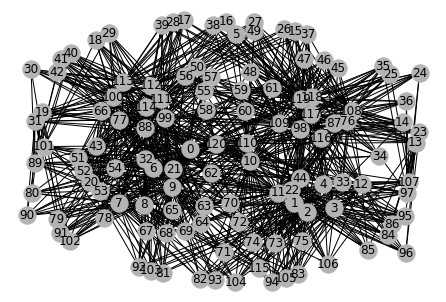

In [ ]:
import networkx as nx
g_c = g.cpu()
nx_G = g_c.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
g.number_of_nodes

<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=121, num_edges=2036,
      ndata_schemes={'norm': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})>

#Run the GCN model (MCI v SMI)


 EPOCH: 0 **************************************************************************************************** 

Epoch 00000 | Time(s) 0.0139 | Train. Loss 2263.5516 | Training Accuracy 0.4579 | Val. Loss 452.513092 | Val. Accuracy 0.5000 ETputs(KTEPS) 146.31

 EPOCH: 1 **************************************************************************************************** 

Epoch 00001 | Time(s) 0.0084 | Train. Loss 926.5566 | Training Accuracy 0.4597 | Val. Loss 604.572266 | Val. Accuracy 0.3333 ETputs(KTEPS) 243.56

 EPOCH: 2 **************************************************************************************************** 

Epoch 00002 | Time(s) 0.0068 | Train. Loss 609.0024 | Training Accuracy 0.4945 | Val. Loss 528.952698 | Val. Accuracy 0.5000 ETputs(KTEPS) 299.22

 EPOCH: 3 **************************************************************************************************** 

Epoch 00003 | Time(s) 0.0059 | Train. Loss 465.5273 | Training Accuracy 0.5183 | Val. Loss 180.009521 | V

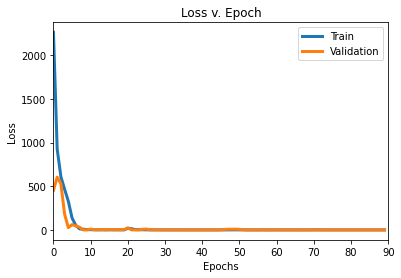

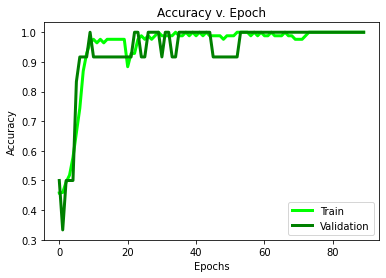

In [ ]:
import matplotlib.pyplot as plt
total_val_accuracies = []
total_train_accuracies = []
total_loss = []
total_val_loss = []

if cuda:
    net.cuda()
loss_fcn = torch.nn.CrossEntropyLoss()

# use optimizer
optimizer = torch.optim.Adam(net.parameters(),
                             lr=args.lr,
                            weight_decay=args.weight_decay)
dur = []
sep = '*' * 100
for epoch in range(args.n_epochs):
  traintest_accs = []
  val_accs = []
  loss_val = []
  val_loss_val = []

  
  print("\n EPOCH: {} {} \n".format(epoch, sep))
  for i in range(len(train_ixs)):
        bins = list(range(len(train_ixs)))
        #print("\n Fold: {} {} \n".format(i, sep))
        train_index = []
        traintest_ix = i
        if traintest_ix == max(bins):
            traintest_ix = 0
            bins.remove(traintest_ix)

        else:
            traintest_ix = traintest_ix + 1
            bins.remove(traintest_ix)
            

        
        traintest_index = train_ixs[traintest_ix]
        traintest_index = torch.LongTensor(traintest_index)
        #print(traintest_index)
        #print(test_index)
        for b in bins:
            train_index = np.concatenate((train_index,train_ixs[b]))
        train_index = torch.LongTensor(train_index)
        #print("Train Items:",len(train_index),"\nTest Items:",len(test_index),"\nValidation Items:",len(val_index))
        #print(train_index)

        net.train()

        
        t0 = time.time()
        # forward
        optimizer.zero_grad()
        logits = net(g, features)
        loss = loss_fcn(logits[train_index], labels[train_index])
        
        
        loss.backward()
        optimizer.step()

          
        dur.append(time.time() - t0)
        
        
        traintest_acc = evaluate(net,g,features, labels, traintest_index)
        traintest_accs = np.append(traintest_accs,traintest_acc)
        
        loss_val.append(loss.item())
        
        


  #print(train_index)
  
  for i in range(len(val_ixs)):
    val_index = val_ixs[i]
    val_index = torch.LongTensor(val_index)
    val_loss = loss_fcn(logits[val_index],labels[val_index])
    #print(val_index)
    val_acc = evaluate(net,g,features, labels, val_index)
    val_accs = np.append(val_accs,val_acc)
    val_loss_val.append(val_loss.item())
  print("Epoch {:05d} | Time(s) {:.4f} | Train. Loss {:.4f} | Training Accuracy {:.4f} | Val. Loss {:4f} | Val. Accuracy {:.4f} "
                "ETputs(KTEPS) {:.2f}". format(epoch, np.mean(dur), np.mean(loss_val),np.mean(traintest_accs),np.mean(val_loss_val),np.mean(val_accs), n_edges / np.mean(dur) / 1000))
  fold_val_avg = np.mean(val_accs)
  fold_train_avg = np.mean(traintest_accs)
  total_val_accuracies = np.append(total_val_accuracies, fold_val_avg)
  total_train_accuracies = np.append(total_train_accuracies, fold_train_avg)
  total_loss = np.append(total_loss,np.mean(loss_val))
  total_val_loss = np.append(total_val_loss,np.mean(val_loss_val))
  
         
 

print("Train Accuracy Avg: {}".format(np.mean(total_train_accuracies[-10:])))
print("Val. Accuracy Avg: {}".format(np.mean(total_val_accuracies[-10:])))
print("Final Loss: {}".format(total_loss[-1]))

fig1, ax1 = plt.subplots()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_xlim((0,args.n_epochs))
ax1.plot(range(args.n_epochs),total_loss,linewidth = 3,label = "Train")
ax1.plot(range(args.n_epochs),total_val_loss,linewidth = 3,label = "Validation")
ax1.set_title("Loss v. Epoch")
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.plot(range(args.n_epochs),total_train_accuracies,linewidth=3,color='lime',label = "Train")
ax2.plot(range(args.n_epochs),total_val_accuracies,linewidth=3,color='green',label = "Validation")
ax2.set_title('Accuracy v. Epoch')
ax2.legend()

plt.show()

#Testing the Model

In [ ]:
net.eval()
test_accs = []
test_loss_val = []
for i in range(len(test_ixs)):
    test_index = test_ixs[i]
    test_index = torch.LongTensor(test_index)
    test_loss = loss_fcn(logits[test_index],labels[test_index])
    #print(test_index)
    test_acc = evaluate(net,g,features, labels, test_index)
    test_accs = np.append(test_accs,test_acc)
    test_loss_val.append(test_loss.item())
print("Test Loss {:4f} |Test Accuracy {:.4f} ". format(np.mean(test_loss_val),np.mean(test_accs)))


Test Loss 0.000000 |Test Accuracy 1.0000 


In [ ]:
from xgboost import XGBRFClassifier
features = features.cpu()
labels = labels.cpu()
xgb_model = XGBRFClassifier(random_state=42)

for i in range(len(train_ixs)):
  train_index = train_ixs[i]
  xgb_model.fit(features[train_index],labels[train_index])
predictions = []
actual = []
correct = 0
for i in range(len(test_ixs)):
  test_index = test_ixs[i]
  preds = xgb_model.predict(features[test_index])
  act = labels[test_index]
  predictions = np.append(predictions,preds)
  actual = np.append(actual,act)
#print(predictions,actual)

for i in range(len(predictions)):
  if predictions[i] == actual[i]:
    correct +=1

bl_test_acc = correct/len(predictions)

print("Baseline Accuracy: {}".format(bl_test_acc))

Baseline Accuracy: 0.4583333333333333
